# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [0]:
# IMPORT LIBRARIES AND PACKAGES

import csv
import math
import numpy as np
from PIL import Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [0]:
import os

project_path = "/content/drive/My Drive/Deep Learning/Project 8 CV1/Dataset/"
os.chdir(project_path)

In [0]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 224 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96

EPOCHS = 50 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 1 # Depends on your GPU or CPU RAM.
PATIENCE = 50 # Patience for early stopping

MULTI_PROCESSING = False # I have a 2 core computer without GPU
THREADS = 1 # I have a 2 core computer without GPU

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)

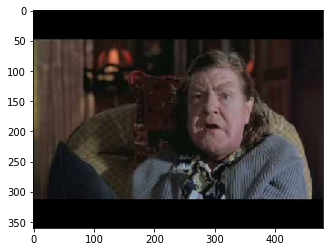

In [0]:
import matplotlib.pyplot as plt

plt.imshow(data[20][0])

In [0]:
print(data[20][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.4979166666666667, 'y': 0.20833333333333334}, {'x': 0.7854166666666667, 'y': 0.6888888888888889}], 'imageWidth': 480, 'imageHeight': 360}]


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [0]:
X_train.shape

(409, 224, 224, 3)

In [0]:
masks.shape

(409, 224, 224)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, masks, test_size = 0.2, random_state = 11)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.42745101  0.03529418 -0.42745095]
  [ 0.44313729  0.05098045 -0.41176468]
  [ 0.45098042  0.05882359 -0.40392154]
  ...
  [-0.41960782 -0.41960782 -0.43529409]
  [-0.41176468 -0.41176468 -0.42745095]
  [-0.39607841 -0.41176468 -0.42745095]]

 [[ 0.44313729  0.05098045 -0.41176468]
  [ 0.45882356  0.06666672 -0.39607841]
  [ 0.4666667   0.06666672 -0.39607841]
  ...
  [-0.34901959 -0.34901959 -0.36470586]
  [-0.372549   -0.372549   -0.38823527]
  [-0.33333331 -0.34901959 -0.36470586]]

 [[ 0.45882356  0.07450986 -0.38823527]
  [ 0.47450984  0.082353   -0.38039213]
  [ 0.47450984  0.082353   -0.372549  ]
  ...
  [ 0.22352946  0.22352946  0.20784318]
  [-0.09803921 -0.09803921 -0.11372548]
  [-0.38823527 -0.41176468 -0.41960782]]

 ...

 [[-0.66274512 -0.65490198 -0.52941179]
  [-0.68627453 -0.67843139 -0.56078434]
  [-0.71764708 -0.7019608  -0.60000002]
  ...
  [-0.77254903 -0.80392158 -0.69411767]
  [-0.75686276 -0.78823531 -0.69411767]
  [-0.77254903 -0.79607844 -0.7019608 ]]

 [

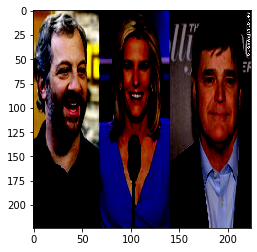

In [0]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

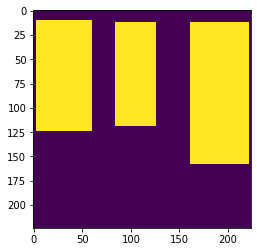

In [0]:
pyplot.imshow(y_train[n])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

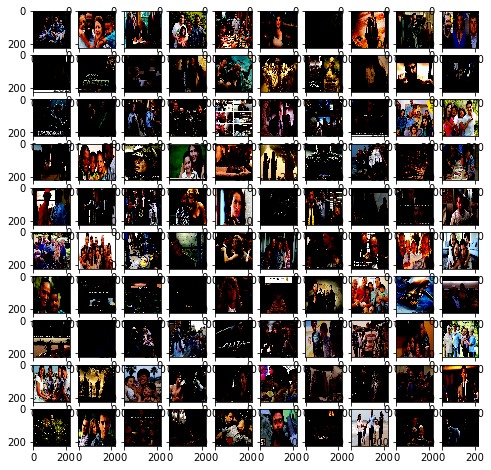

In [0]:
w=10
h=10
fig=pyplot.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    pyplot.imshow(img, cmap='gray')
pyplot.show()

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(286, 224, 224, 3)
(286, 224, 224)
(123, 224, 224, 3)
(123, 224, 224)


In [0]:
X_train[0]

array([[[ 0.60000002,  0.34117651, -0.20784312],
        [ 0.57647061,  0.33333337, -0.17647058],
        [ 0.63137257,  0.38823533, -0.11372548],
        ...,
        [ 0.49803925,  0.53725493,  0.56862748],
        [ 0.49019611,  0.52941179,  0.56078434],
        [ 0.45098042,  0.49019611,  0.51372552]],

       [[ 0.60784316,  0.34901965, -0.19215685],
        [ 0.59215689,  0.34901965, -0.1607843 ],
        [ 0.65490198,  0.4039216 , -0.08235294],
        ...,
        [ 0.51372552,  0.5529412 ,  0.58431375],
        [ 0.48235297,  0.52156866,  0.5529412 ],
        [ 0.43529415,  0.47450984,  0.49803925]],

       [[ 0.63137257,  0.37254906, -0.17647058],
        [ 0.60784316,  0.36470592, -0.14509803],
        [ 0.67843139,  0.42745101, -0.05098039],
        ...,
        [ 0.50588238,  0.54509807,  0.57647061],
        [ 0.47450984,  0.52156866,  0.54509807],
        [ 0.44313729,  0.48235297,  0.50588238]],

       ...,

       [[ 0.77254903,  0.71764708,  0.51372552],
        [ 0

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") # Load pre-trained mobilenet

    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [43]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss=loss, metrics = [dice_coefficient])

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [47]:
model.fit(X_train,y_train,
          batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1,
          validation_data=(X_test, y_test))

Train on 286 samples, validate on 123 samples
Epoch 1/50
285/286 [============================>.] - ETA: 0s - loss: 0.4757 - dice_coefficient: 0.7270
Epoch 00001: loss improved from 0.48350 to 0.47712, saving model to model-0.48.h5
286/286 [==============================] - 14s 48ms/sample - loss: 0.4771 - dice_coefficient: 0.7261 - val_loss: 1.2142 - val_dice_coefficient: 0.5228
Epoch 2/50
285/286 [============================>.] - ETA: 0s - loss: 0.4434 - dice_coefficient: 0.7415
Epoch 00002: loss improved from 0.47712 to 0.44322, saving model to model-0.44.h5
286/286 [==============================] - 13s 47ms/sample - loss: 0.4432 - dice_coefficient: 0.7414 - val_loss: 1.0732 - val_dice_coefficient: 0.5569
Epoch 3/50
285/286 [============================>.] - ETA: 0s - loss: 0.4203 - dice_coefficient: 0.7513
Epoch 00003: loss improved from 0.44322 to 0.42044, saving model to model-0.42.h5
286/286 [==============================] - 13s 46ms/sample - loss: 0.4204 - dice_coefficient: 

### Get the predicted mask for a sample image   (3 marks)

[[4.5580855e-08 4.5580855e-08 4.3769759e-08 ... 8.2252808e-07
  5.8957602e-07 5.8957602e-07]
 [4.5580855e-08 4.5580855e-08 4.3769759e-08 ... 8.2252808e-07
  5.8957602e-07 5.8957602e-07]
 [7.9555619e-08 7.9555619e-08 1.5915819e-07 ... 3.7013040e-06
  1.1410806e-06 1.1410806e-06]
 ...
 [1.4136072e-17 1.4136072e-17 3.4348241e-17 ... 5.1389871e-30
  1.3065764e-30 1.3065764e-30]
 [1.8539740e-17 1.8539740e-17 9.1359898e-18 ... 1.3856429e-30
  2.0592532e-30 2.0592532e-30]
 [1.8539740e-17 1.8539740e-17 9.1359898e-18 ... 1.3856429e-30
  2.0592532e-30 2.0592532e-30]]


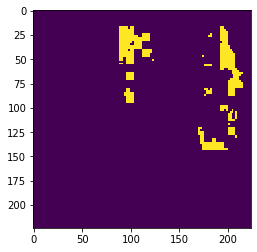

In [48]:
n = 10
sample_image = X_train[n]

region = model.predict(x=np.array([sample_image]))[0]
print(region)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > 0.95:
          region[i][j]=1;
        else:
          region[i][j]=0;  
plt.imshow(region)

### Impose the mask on the image (3 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


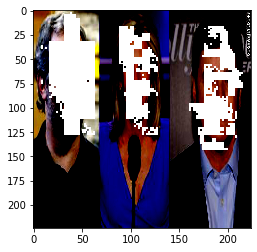

In [49]:
Maskimage = X_train[10];
Maskimage.shape
for k in range(Maskimage.shape[2]):  
    for j in range(Maskimage.shape[1]):
        for i in range(Maskimage.shape[0]):
            if region[i][j]==1:
              Maskimage[i][j][k]=1  
                  

plt.imshow(Maskimage)